# UNCC Building Recognition Modeling

**Note: It is recommended to have 8GB of ram on your system to run this code. If you have less, it is recommended to decrease the size of the images to 64x64**

In [1]:
#Imports needed for modeling

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from sklearn import svm

In [2]:
%cd 4152_Building_Pictures/new_data

e:\Group2CompVisProject\4152_Building_Pictures\new_data


In [3]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[8:] for name in glob.glob('./train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False):    
    data = []
    labels = []    
    channel_num = 3 if is_color else 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)
            
   
    # Data Augmentation 
    if augment: 
        
      augment = []

      for img in data:
        img_flip = np.fliplr(img)
        augment.append(img_flip)

      data = data + augment  
      labels = labels + labels


    # Data Normalization
    if zero_centered:
        
      mean = np.mean(data, axis=0)
      for idx, img in enumerate(data):
        data[idx] = img - mean

         
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []
        
         
        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
           
        
        data, labels = batch_data, batch_labels 
        
    
    return zip(batch_data, batch_labels)

class_names: {0: '12 - Smith', 1: '17 - Belk Gym', 2: '32 - Colvard', 3: '34 - Prospector', 4: '38 - Burson', 5: '4 - Atkins', 6: '46 - SAC', 7: '52 - Cato', 8: '56 - Woodward', 9: '63 - CHHS', 10: '69 - Student Union', 11: '96 - UREC'} 


## Training Function Definition

Loss Function: Cross Entropy Loss


In [5]:
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  
  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
   
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)

## Evaluation Function Definition

In [6]:
import time
  
def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))

## Load Images

In [7]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 32 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./train/', img_size, num_per_class=100, batch_size=batch_size, shuffle=True, 
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./val/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 48 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 10 minibatches (batch_size=32) of testing samples.


46 - SAC


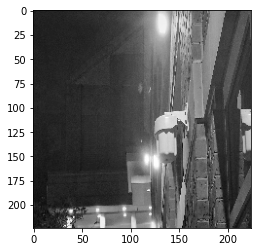

In [8]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_large[0][0][10][0], trainloader_large[0][1][10]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Train + Eval Model

In [9]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------

train_option={}
train_option['lr'] = 0.0001
train_option['epoch'] = 15
train_option['device'] = 'gpu'

model = torchvision.models.resnet50(pretrained = True)

model.fc = nn.Linear(2048, 12)

trainModel(model, trainloader_large, train_option, testloader_large)

c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 | Iter:    0 | Time: 00:00:05 | Train Loss: 2.4308 | Average Loss: 2.4308 
Epoch: 1 | Iter:   20 | Time: 00:00:08 | Train Loss: 1.2069 | Average Loss: 1.7808 
Epoch: 1 | Iter:   40 | Time: 00:00:11 | Train Loss: 0.5769 | Average Loss: 1.3653 
Accuracy: 0.800000 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:13 | Train Loss: 0.2033 | Average Loss: 1.2173 
Epoch: 2 | Iter:   20 | Time: 00:00:16 | Train Loss: 0.1135 | Average Loss: 0.9191 
Epoch: 2 | Iter:   40 | Time: 00:00:19 | Train Loss: 0.0738 | Average Loss: 0.7317 
Accuracy: 0.837500 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:21 | Train Loss: 0.0244 | Average Loss: 0.6746 
Epoch: 3 | Iter:   20 | Time: 00:00:24 | Train Loss: 0.0230 | Average Loss: 0.5633 
Epoch: 3 | Iter:   40 | Time: 00:00:27 | Train Loss: 0.0094 | Average Loss: 0.4834 
Accuracy: 0.859375 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:28 | Train Loss: 0.0072 | Average Loss: 0.4572 
Epoch: 4 | Iter:   20 | Time: 00:00:32 | Train Loss:

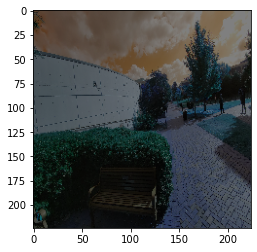

Prediction:  34 - Prospector


In [11]:
#Input an image and get a prediction of the class
def img_load(file_path):
    
    img = cv2.imread(file_path)
    img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
    img = np.transpose(img, [2, 0, 1])
    return img.astype(np.float)/(255*2-1)

# show some images
def displayimg(img):
     # unnormalize
    if len(img.shape) > 2:
        img = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(img, 'gray')
    plt.show()


def predict(net, img, device='gpu'):
    net.eval()
    if device == 'gpu':
        net = net.cuda()
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = Variable(img).float()
    if device == 'gpu':
        img = img.cuda()
    outputs = net(img)
    return outputs.max(1)[1].item()

def convert_label(label):
    return class_names[label]

img = img_load('./val/34 - Prospector/Prospector (209).jpg')

prediction = (predict(model, img))
displayimg(img)
print("Prediction: ", convert_label(prediction))


